In [26]:
import pandas as pd
import numpy as np
import bs4
import requests
import time
import matplotlib.pyplot as plt
import codecs
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score

import pickle

# 1) Parsing of the training set

In [7]:
%%time
# Parsing of areviews.ru site
path = "C:\\Users\\All\\Курс 6. Финальный проект\\Неделя 6"
os.chdir(path)
counter = 0 
with open("areviews.txt") as links_file:
    for link in links_file:
        t_sleep = np.random.randint(1, 100) * 0.01 # It's better to wait for up to 1 s in order to avoid a ban
        time.sleep(t_sleep) 
        req = requests.get(link[:-1])         # Making a request for the current link
        soup = bs4.BeautifulSoup(req.text, 'lxml') # The text of all reviews is in req.text
        reviews_parser = soup.find('ul', attrs={'class', 'comment_list'}).findAll('li')
        for review in reviews_parser:            
            review_parts = review.findAll('p') # Finding the text of the review
            for res in review_parts:
                counter += 1
                if res.findChild('b').text == u"Достоинства:": # ADVANTAGES are classified as positive reviews 
                    with open("pos/"+str(counter)+".txt", 'w') as fid:
                        fid.write(str(res.text[12:].strip().lower()))
                if res.findChild('b').text == u"Недостатки:": # DISADVANTAGES are classified as negative reviews 
                    with open("neg/"+str(counter)+".txt", 'w') as fid:
                        fid.write(str(res.text[11:].strip().lower()))

Wall time: 23.3 s


So far we have 1330 of negative and positive reviews each. The training set is well balanced.

# 2) Data labeling for pipeline training (vectorizer + classifier)


In [13]:
train = pd.DataFrame(columns = ['text']) #Training set dataframe
labels = 1330 * [1] + 1330 * [0] # A list with class labels

In [14]:
#Filling the dataframe with positive reviews
path = "C:\\Users\\All\\Курс 6. Финальный проект\\Неделя 6\\pos"
os.chdir(path)
list_of_pos = os.listdir()
counter = 0
for file in list_of_pos:
    text = ""
    with open (file, 'r') as f_obj: 
        for line in f_obj.readlines():
            text += line.strip()
    train.loc[counter] = [text]
    counter += 1

In [15]:
#Filling the dataframe with negative reviews
path = "C:\\Users\\All\\Курс 6. Финальный проект\\Неделя 6\\neg"
os.chdir(path)
list_of_neg = os.listdir()
for file in list_of_neg:
    text = ""
    with open (file, 'r') as f_obj: 
        for line in f_obj.readlines():
            text += line.strip()
    train.loc[counter] = [text]
    counter += 1

# 3) Looking for an optimal pipeline

In [16]:
# Making a CountVectorizer + LinearSVC pipeline
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords.words("russian"))), ('SVC', LinearSVC())])
# Calculation of accuracy on 5 folds
print('The mean accuracy of the default SVC', cross_val_score(pipe, train['text'], labels, scoring='accuracy', cv=5).mean())

The mean accuracy of the default SVC 0.8845864661654135


In [17]:
# Making a TfIDFVectorizer + LinearSVC pipeline
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words("russian"))), ('SVC', LinearSVC())])
# Calculation of accuracy on 5 folds
print('The mean accuracy of the improved SVC', cross_val_score(pipe, train['text'], labels, scoring='accuracy', cv=5).mean())

The mean accuracy of the improved SVC 0.9195488721804512


TfIdf works a bit better than CountVectorizer. Let's try to fit the parameters.

In [18]:
scores = []
n_gram_max = np.arange(1, 10, 1)
for i in n_gram_max:
    pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words("russian"), ngram_range = (1, i))), ('SVC', LinearSVC())])
    scores.append(cross_val_score(pipe, train['text'], labels, scoring='accuracy', cv=5).mean())

No handles with labels found to put in legend.


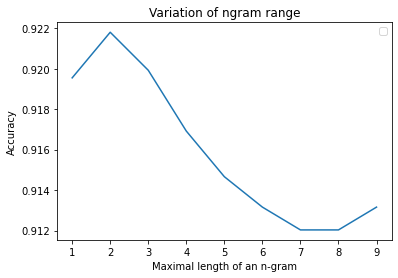

In [19]:
plt.title("Variation of ngram range")
plt.plot(n_gram_max, scores)
plt.xlabel("Maximal length of an n-gram")
plt.ylabel("Accuracy")
plt.legend()

Apparently, the best size of an n-gram is 2. Hereinafter, we'll work with bigrams. Let's try to fit min_df.

In [20]:
scores = []
min_df = np.arange(1, 20, 1)
for i in min_df:
    pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words("russian"), ngram_range = (1, 2), 
                                             min_df = i)), ('SVC', LinearSVC())])
    scores.append(cross_val_score(pipe, train['text'], labels, scoring='accuracy', cv=5).mean())

No handles with labels found to put in legend.


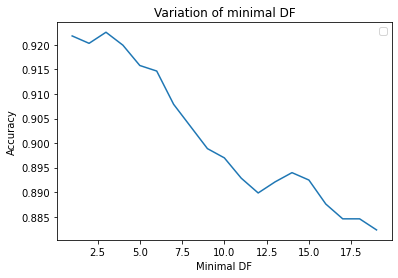

In [21]:
plt.title("Variation of minimal DF")
plt.plot(min_df, scores)
plt.xlabel("Minimal DF")
plt.ylabel("Accuracy")
plt.legend()

Trying to fit max_df.

In [22]:
scores = []
max_df = np.arange(0, 20, 1)
for i in max_df:
    pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words("russian"), ngram_range = (1, 2), 
                                             max_df = i)), ('SVC', LinearSVC())])
    scores.append(cross_val_score(pipe, train['text'], labels, scoring='accuracy', cv=5).mean())

C:\Users\All\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\All\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\All\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\All\anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\All\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\All\anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Al

No handles with labels found to put in legend.


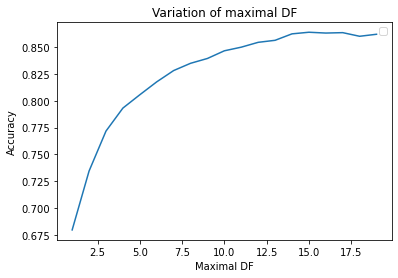

In [23]:
plt.title("Variation of maximal DF")
plt.plot(max_df, scores)
plt.xlabel("Maximal DF")
plt.ylabel("Accuracy")
plt.legend()

In fact, limitations of DF don't make changes. Let's now fit the pipeline to the training set.

In [24]:
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words("russian"), ngram_range = (1, 2), 
                                             )), ('SVC', LinearSVC())])
pipe.fit(train['text'], labels)

Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('SVC', LinearSVC())])

# 4) Verification and pickling of the model

In [28]:
pos_review = ['очень приятно держать телефон в руках. тонкий, стильный.'] # Positive review
neg_review = ['очень мало памяти, качество передней камеры - плохое'] # negative review

print(pipe.predict(pos_review)[0])
print(pipe.predict(neg_review)[0])

with open('sentiment_classifier.pkl', 'wb') as f:  # pickling of the pipeline
    pickle.dump(pipe, f)

1
0
